# Langgraph with AgentNeo Integration
 This Jupyter notebook demonstrates the integration of AgentNeo, a powerful tracing and monitoring tool, with Langgraph, a graph-based approach to managing language models with an agent-based system to enhance the automation and decision-making capabilities of your application. This integration allows for comprehensive analysis and debugging of AI-powered systems.

 # Setup and Imports
First, let's import the necessary libraries and set up our environment.

In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:

import os
import uuid
from dotenv import load_dotenv
from typing import List, Literal, Annotated
from typing_extensions import TypedDict
import openai

from langchain_core.messages import (
    SystemMessage, 
    HumanMessage, 
    AIMessage, 
    ToolMessage
)
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages


# Load environment variables from .env file
load_dotenv()

# Initialize OpenAI API using environment variables
openai.api_key = os.getenv("OPENAI_API_KEY")



 # Initialize AgentNeo Session and Tracer
 Now, let's set up our AgentNeo session and tracer.



In [3]:
from agentneo import AgentNeo, Tracer, Execution


# Initialize AgentNeo session
neo_session = AgentNeo(session_name="recipe_builder_assistant")
try:
    neo_session.create_project(project_name="Recipe_Builder")
except:
    neo_session.connect_project(project_name="Recipe_Builder")

# Create tracer
tracer = Tracer(session=neo_session)
tracer.start()

INFO:httpx:HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


Project 'Recipe_Builder' found.
Tracing Started.



 # Define Agents and Tools
Now, let's create our AI tools using langgraph.

In [4]:
@tracer.trace_agent(name="RecipeInstructions")
class RecipeInstructions(BaseModel):
    """Instructions for creating a recipe."""
    dish_name: str
    servings: int
    dietary_restrictions: List[str]
    cooking_time: str
    difficulty_level: str
    ingredients: List[str]
    special_equipment: List[str]

@tracer.trace_agent(name="RecipeBuilder")
class RecipeBuilder:
    def __init__(self):
        self.template = """You are a helpful recipe building assistant. Your job is to help users create and customize recipes.

You should gather the following information:
- Name of the dish they want to make
- Number of servings needed
- Any dietary restrictions or preferences
- Desired cooking time
- Cooking skill level
- Available ingredients or preferred ingredients
- Available cooking equipment

If any information is missing or unclear, ask for clarification. Once you have all the necessary information, call the relevant tool to generate the recipe.

Remember to:
- Be specific about ingredient quantities
- Consider dietary restrictions carefully
- Suggest alternatives for uncommon ingredients
- Provide clear, step-by-step instructions"""

        self.llm = ChatOpenAI(temperature=0.7)
        self.llm_with_tool = self.llm.bind_tools([RecipeInstructions])

    @tracer.trace_tool(name="get_messages_info")
    def get_messages_info(self, messages):
        return [SystemMessage(content=self.template)] + messages

    @tracer.trace_tool(name="info_chain")
    def info_chain(self, state):
        messages = self.get_messages_info(state["messages"])
        response = self.llm_with_tool.invoke(messages)
        return {"messages": [response]}

    @tracer.trace_tool(name="get_recipe_messages")
    def get_recipe_messages(self, messages: list):
        tool_call = None
        other_msgs = []
        for m in messages:
            if isinstance(m, AIMessage) and m.tool_calls:
                tool_call = m.tool_calls[0]["args"]
            elif isinstance(m, ToolMessage):
                continue
            elif tool_call is not None:
                other_msgs.append(m)
        
        recipe_system = """Based on the following requirements, create a detailed recipe with:
1. List of ingredients with quantities
2. Required equipment
3. Step-by-step preparation instructions
4. Cooking tips and timing
5. Serving suggestions
6. Storage instructions if applicable

Recipe Requirements:
{reqs}"""
        return [SystemMessage(content=recipe_system.format(reqs=tool_call))] + other_msgs

    @tracer.trace_tool(name="recipe_gen_chain")
    def recipe_gen_chain(self, state):
        messages = self.get_recipe_messages(state["messages"])
        response = self.llm.invoke(messages)
        return {"messages": [response]}

In [5]:
@tracer.trace_agent(name="NutritionAnalyzer")
class NutritionAnalyzer:
    def __init__(self):
        self.template = """You are a nutrition analysis assistant. Your job is to analyze the nutritional content of recipes.

Given a recipe, you should provide:
1. Total calories per serving
2. Macronutrient breakdown (protein, carbs, fats)
3. Key vitamins and minerals
4. Potential allergens
5. Suggestions for making the recipe healthier (if applicable)

Be as accurate as possible with your estimations. If you're unsure about any information, state that it's an approximation."""

        self.llm = ChatOpenAI(temperature=0.3)

    @tracer.trace_tool(name="get_nutrition_messages")
    def get_nutrition_messages(self, messages):
        recipe = None
        for m in messages:
            if isinstance(m, AIMessage) and not m.tool_calls:
                recipe = m.content
                break
        
        if recipe is None:
            return [SystemMessage(content="No recipe found to analyze.")]
        
        return [
            SystemMessage(content=self.template),
            HumanMessage(content=f"Please analyze the nutritional content of this recipe:\n\n{recipe}")
        ]

    @tracer.trace_tool(name="nutrition_analysis_chain")
    def nutrition_analysis_chain(self, state):
        messages = self.get_nutrition_messages(state["messages"])
        response = self.llm.invoke(messages)
        return {"messages": [response]}

In [6]:
@tracer.trace_agent(name="CookingTipsAgent")
class CookingTipsAgent:
    def __init__(self):
        self.template = """You are a cooking tips and techniques expert. Your job is to provide helpful advice and tips for the given recipe.

Given a recipe, you should provide:
1. General cooking techniques relevant to the recipe
2. Tips for ingredient preparation
3. Suggestions for enhancing flavors
4. Common mistakes to avoid
5. Time-saving tricks (if applicable)
6. Plating and presentation ideas

Ensure your tips are specific to the recipe and helpful for cooks of all skill levels."""

        self.llm = ChatOpenAI(temperature=0.5)

    @tracer.trace_tool(name="get_cooking_tips_messages")
    def get_cooking_tips_messages(self, messages):
        recipe = None
        for m in messages:
            if isinstance(m, AIMessage) and not m.tool_calls:
                recipe = m.content
                break
        
        if recipe is None:
            return [SystemMessage(content="No recipe found to provide tips for.")]
        
        return [
            SystemMessage(content=self.template),
            HumanMessage(content=f"Please provide cooking tips and techniques for this recipe:\n\n{recipe}")
        ]

    @tracer.trace_tool(name="cooking_tips_chain")
    def cooking_tips_chain(self, state):
        messages = self.get_cooking_tips_messages(state["messages"])
        response = self.llm.invoke(messages)
        return {"messages": [response]}

# Managing state graphs, saving memory, handling messages, and typing annotations.

In [7]:
# State management

@tracer.trace_tool(name="get_state")
def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif isinstance(messages[-1], AIMessage) and not messages[-1].tool_calls:
        if any("nutrition" in m.content.lower() for m in messages[-3:]):
            return "cooking_tips"
        return "nutrition_analysis"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

@tracer.trace_agent(name="State")
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize workflow
memory = MemorySaver()
workflow = StateGraph(State)

# Initialize agents
recipe_builder = RecipeBuilder()
nutrition_analyzer = NutritionAnalyzer()
cooking_tips_agent = CookingTipsAgent()

# Add nodes to workflow
workflow.add_node("info", recipe_builder.info_chain)
workflow.add_node("recipe", recipe_builder.recipe_gen_chain)
workflow.add_node("nutrition_analysis", nutrition_analyzer.nutrition_analysis_chain)
workflow.add_node("cooking_tips", cooking_tips_agent.cooking_tips_chain)

@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Recipe generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

# Add edges to workflow
workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", "nutrition_analysis", "cooking_tips", END])
workflow.add_edge("add_tool_message", "recipe")
workflow.add_edge("recipe", "nutrition_analysis")
workflow.add_edge("nutrition_analysis", "cooking_tips")
workflow.add_edge("cooking_tips", END)
workflow.add_edge(START, "info")

# Compile graph
graph = workflow.compile(checkpointer=memory)

# Displaying a PNG image of a graph generated from a LangGraph instance using Mermaid visualization

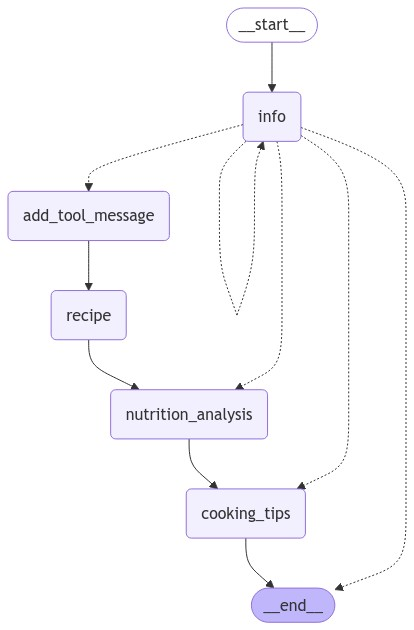

In [8]:
# %% 
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Main interaction loop
def run_interaction():
    cached_human_responses = [
        "I want to make chocolate chip cookies",
        "6 servings, no nuts, beginner friendly, 30 minutes cooking time",
        "I have basic baking equipment and ingredients",
        "Can you analyze the nutritional content of this recipe?",
        "Any cooking tips for making these cookies?",
        "q"
    ]
    cached_response_index = 0
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    while True:
        try:
            user = input("User (q/Q to quit): ")
        except:
            user = cached_human_responses[cached_response_index]
            cached_response_index += 1
            
        print(f"User (q/Q to quit): {user}")
        
        if user in {"q", "Q"}:
            print("AI: Thank you for using the Recipe Builder, Nutrition Analyzer, and Cooking Tips Assistant! Happy cooking!")
            break
            
        output = None
        for output in graph.stream(
            {"messages": [HumanMessage(content=user)]}, 
            config=config, 
            stream_mode="updates"
        ):
            last_message = next(iter(output.values()))["messages"][-1]
            last_message.pretty_print()

        if output and "cooking_tips" in output:
            print("Recipe, nutrition analysis, and cooking tips completed! Let me know if you need any modifications or have questions!")


# Metrics Evaluation System

In [10]:

# Metrics Evaluation System
def execute_metrics(neo_session, trace_id):
    """Execute and return metrics analysis."""
    exe = Execution(session=neo_session, trace_id=trace_id)
    exe.execute(metric_list=[
        'goal_decomposition_efficiency',
        'goal_fulfillment_rate',
        'tool_call_success_rate_metric'
    ])
    return exe.get_results()

def print_metrics_results(metric_results):
    """Print the metrics results in a formatted way."""
    print("\nMetrics Results:")
    print(metric_results)

def launch_metrics_dashboard(neo_session):
    """Launch the AgentNeo metrics dashboard."""
    neo_session.launch_dashboard()

In [11]:
if __name__ == "__main__":
    try:
        run_interaction()
    finally:
        tracer.stop()
        print(f"Trace ID: {tracer.trace_id}")
        


User (q/Q to quit): I want to make panner pizza for 4 members


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Great choice! I can help you with that. Could you please provide me with the following information:
1. Any dietary restrictions or preferences?
2. Desired cooking time?
3. Cooking skill level?
4. Do you have any available ingredients or preferred ingredients?
5. Do you have any available cooking equipment?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

To analyze the nutritional content of a recipe, I don't need specific details like cooking time, skill level, or equipment. However, it would be helpful to know if there are any dietary restrictions or preferences, as well as any key ingredients in the recipe. Once you provide me with the recipe and any additional information, I can proceed with the analysis.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

I see you're looking for cooking tips and techniques for a recipe. Could you please provide me with the details listed above so I can tailor my advice to your needs?
Recipe, nutrition analysis, and cooking tips completed! Let me know if you need any modifications or have questions!
User (q/Q to quit): no,4 hours,basic,no,no  also gice me the proteins in that


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Great! Let's proceed with creating the paneer pizza recipe for 4 servings. I will also calculate the protein content in the recipe. 

Let's start with the ingredients for the paneer pizza. Could you please confirm if you have the following ingredients or if you have any preferences for them?
1. Pizza dough
2. Pizza sauce
3. Paneer (cottage cheese)
4. Bell peppers (capsicum)
5. Onion
6. Cheese (mozzarella or any preferred cheese)
7. Olive oil
8. Herbs and spices (like oregano, chili flakes, salt, pepper)

Once you confirm the ingredients, I will proceed with generating the recipe and calculating the protein content.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

I don't have any dietary restrictions. I'm looking for a recipe that takes around 30 minutes to cook. I would say my cooking skill level is intermediate. I have basic ingredients like chicken, vegetables, rice, and spices. I have a stove, oven, pots, and pans for cooking.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Great! Here are some general cooking tips and techniques for making a classic Spaghetti Carbonara:

1. **General Cooking Techniques**:
   - Use a large pot to cook the spaghetti in plenty of salted boiling water until al dente.
   - Cook the pancetta or guanciale until crispy before adding it to the pasta.
   - Toss the hot pasta with the egg and cheese mixture off the heat to avoid scrambling the eggs.
   - Reserve some pasta water to adjust the consistency of the sauce if needed.

2. **Tips for Ingredient Preparation**:
   - Grate the cheese fresh for the best flavor and texture.
   - Use fresh eggs at room temperature for a creamy sauce.
   - Chop the pancetta or guanciale into small pieces for even cooking and distribution in the pasta.

3. **Suggestions for Enhancing Flavors**:
   - Add freshly cracked black pepper for a nice kick of flavor.
   - Consider using a mix of Pecorino Romano and Parmigiano

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  RecipeInstructions (call_e2bYXhqTjrd1q2NmVzspVAqI)
 Call ID: call_e2bYXhqTjrd1q2NmVzspVAqI
  Args:
    dish_name: Paneer Pizza
    servings: 4
    dietary_restrictions: []
    cooking_time: 4 hours
    difficulty_level: Basic
    ingredients: ['Pizza dough', 'Pizza sauce', 'Paneer (cottage cheese)', 'Bell peppers (capsicum)', 'Onion', 'Cheese (mozzarella or preferred cheese)', 'Olive oil', 'Herbs and spices (oregano, chili flakes, salt, pepper)']
    special_equipment: []
================================= Tool Message =================================

Recipe generated!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Paneer Pizza Recipe

Ingredients:
- Pizza dough (enough for a 12-inch pizza)
- 1/2 cup Pizza sauce
- 200g Paneer (cottage cheese), cubed
- 1 Bell pepper (capsicum), thinly sliced
- 1 Onion, thinly sliced
- 1 cup Cheese (mozzarella or preferred cheese), shredded
- 2 tbsp Olive oil
- Herbs and spices: Oregano, Chili flakes, Salt, Pepper

Equipment:
- Oven
- Baking tray or pizza stone
- Rolling pin
- Cutting board
- Knife
- Mixing bowls
- Spoon

Step-by-step Preparation Instructions:

1. Preheat the oven to 220°C (425°F).

2. Roll out the pizza dough on a floured surface to fit the size of your baking tray or pizza stone.

3. Place the rolled out dough on the baking tray or pizza stone.

4. Spread the pizza sauce evenly over the dough, leaving a small border around the edges.

5. Arrange the cubed paneer, sliced bell peppers, and onions on top of the sauce.

6. Sprinkle the shredded cheese over the vegetable

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

I don't have any dietary restrictions, and I'm open to any suggestions for making the recipe healthier. I have about 45 minutes to cook, and I would say I have an intermediate cooking skill level. I have a well-stocked pantry and fridge, so feel free to suggest any ingredients. I have basic cooking equipment like pots, pans, and utensils.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

I can provide general tips and techniques for a chicken stir-fry recipe:

1. **General Cooking Techniques**:
   - **High Heat**: Stir-frying requires high heat to cook the ingredients quickly while maintaining their texture and color.
   - **Prep Work**: Have all your ingredients chopped and ready to go before you start cooking. Stir-frying is a fast process, and you don't want to be chopping while things are cooking.

2. **Tips for Ingredient Preparation**:
   - **Thinly Sliced Chicken**: For quick and even cooking, slice the chicken into thin strips or bite-sized pieces.
   - **Uniformly Cut Vegetables**: Cut vegetables into similar sizes to ensure they cook at the same rate.
   - **Marinate the Chicken**: Marinating the chicken in a mixture of soy sauce, garlic, and ginger can add flavor and tenderize the meat.

3. **Suggestions for Enhancing Flavors**:
   - **Aromatics**: Use garlic, ginger, and green

In [12]:
results = execute_metrics(neo_session, tracer.trace_id)


12:59:33 - LiteLLM:INFO: utils.py:2686 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
12:59:47 - LiteLLM:INFO: utils.py:937 - Wrapper: Completed Call, calling success_handler
INFO:LiteLLM:Wrapper: Completed Call, calling success_handler
12:59:47 - LiteLLM:INFO: utils.py:2686 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
12:59:57 - LiteLLM:INFO: utils.py:937 - Wrapper: Completed Call, calling success_handler
INFO:LiteLLM:Wrapper: Completed Call, calling success_handler
12:59:57 - LiteLLM:INFO: utils.py:2686 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o-mini; provider = o

In [13]:
# Display results
print_metrics_results(results)
        



Metrics Results:
[{'metric_name': 'goal_decomposition_efficiency', 'score': 0.85, 'reason': "The decomposition of the original goal into sub-tasks is largely effective, covering all necessary aspects of creating a recipe. The tools are appropriately assigned to each sub-task, and the logical sequence is clear, allowing for efficient execution. However, there could be slight improvements in granularity, particularly in the confirmation of ingredients, which could be more detailed. Overall, the sub-tasks are well-defined and facilitate achieving the user's goal.", 'result_detail': {'metric_name': 'goal_fulfillment_rate', 'config': {}, 'result': {'originalGoal': 'The user intends to create a paneer pizza for four people and is seeking assistance in generating a detailed recipe, including nutritional information.', 'subtasks': ['Gather the following information: Name of the dish, Number of servings, Dietary restrictions, Desired cooking time, Cooking skill level, Available ingredients, Av

In [14]:
results

[{'metric_name': 'goal_decomposition_efficiency',
  'score': 0.85,
  'reason': "The decomposition of the original goal into sub-tasks is largely effective, covering all necessary aspects of creating a recipe. The tools are appropriately assigned to each sub-task, and the logical sequence is clear, allowing for efficient execution. However, there could be slight improvements in granularity, particularly in the confirmation of ingredients, which could be more detailed. Overall, the sub-tasks are well-defined and facilitate achieving the user's goal.",
  'result_detail': {'metric_name': 'goal_fulfillment_rate',
   'config': {},
   'result': {'originalGoal': 'The user intends to create a paneer pizza for four people and is seeking assistance in generating a detailed recipe, including nutritional information.',
    'subtasks': ['Gather the following information: Name of the dish, Number of servings, Dietary restrictions, Desired cooking time, Cooking skill level, Available ingredients, Avai

In [15]:
# Launch dashboard
launch_metrics_dashboard(neo_session)

INFO:root:Dashboard launched successfully. Access it at: http://localhost:3000
